In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
# SEED = 147
# SEED = 258
SEED = 369

torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
import torch.optim as optim
from torch.utils import data

In [5]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
## demo of train loader
xx, yy = iter(train_loader).next()
xx.shape

torch.Size([32, 3, 32, 32])

# Model

In [8]:
from transformers_lib import TransformerBlock, \
        Mixer_TransformerBlock_Encoder, \
        PositionalEncoding, \
        ViT_Classifier

In [9]:
class Mixer_ViT_Classifier(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_expansion:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
        final_dim = int(__patch_size*hidden_expansion/2)*2
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"ViT Mixer : Channes per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.transformer_blocks = []
        
        f = self.get_factors(self.channel_dim)
        print(f)
        fi = np.abs(np.array(f) - np.sqrt(self.channel_dim)).argmin()
        
        _n_heads = f[fi]
        
        ## number of dims per channel -> channel_dim
        print('Num patches',self.patch_dim)
        print(self.channel_dim, _n_heads)
        
        ### Find the block size for sequence:
        block_seq_size = int(2**np.ceil(np.log2(np.sqrt(16))))
        
#         block = int(np.ceil(np.sqrt(self.patch_dim)))
        for i in range(num_blocks):
            L = Mixer_TransformerBlock_Encoder(self.patch_dim, block_seq_size, self.channel_dim, _n_heads, 0, 2)
            self.transformer_blocks.append(L)
        self.transformer_blocks = nn.Sequential(*self.transformer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        self.positional_encoding = PositionalEncoding(self.channel_dim, dropout=0)
        
        
    def get_factors(self, n):
        facts = []
        for i in range(2, n+1):
            if n%i == 0:
                facts.append(i)
        return facts
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
#         x = self.positional_encoding(x)
        x = self.transformer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [10]:
vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[4, 4], hidden_expansion=2.4, num_blocks=1, num_classes=10)

ViT Mixer : Channes per patch -> Initial:48 Final:114
[2, 3, 6, 19, 38, 57, 114]
Num patches 64
114 6


In [11]:
vit_mixer

Mixer_ViT_Classifier(
  (unfold): Unfold(kernel_size=[4, 4], dilation=1, padding=0, stride=[4, 4])
  (channel_change): Linear(in_features=48, out_features=114, bias=True)
  (transformer_blocks): Sequential(
    (0): Mixer_TransformerBlock_Encoder(
      (sparse_transformers): ModuleList(
        (0): Sparse_TransformerBlock(
          (attention): SelfAttention_Sparse(
            (values): Linear(in_features=114, out_features=114, bias=True)
            (keys): Linear(in_features=114, out_features=114, bias=True)
            (queries): Linear(in_features=114, out_features=114, bias=True)
            (fc_out): Linear(in_features=114, out_features=114, bias=True)
          )
          (norm1): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
          (feed_forward): Sequential(
            (0): Linear(in_features=114, out_features=228, bias=True)
            (1): GELU()
            (2): Linear(in_features=228, out_features=114, bias=True)
          )
          (norm2): LayerNorm((

In [12]:
vit_mixer(torch.randn(1, 3, 32, 32)).shape

torch.Size([1, 10])

In [13]:
asdasd

NameError: name 'asdasd' is not defined

#### Final Model

In [14]:
torch.manual_seed(SEED)
# model = ViT_Classifier((3, 32, 32), patch_size=[4, 4], hidden_expansion=2.4, num_blocks=6, num_classes=10, pos_emb=False)
model = Mixer_ViT_Classifier((3, 32, 32), patch_size=[4, 4], hidden_expansion=2.4, num_blocks=2, num_classes=10)
model = model.to(device)

ViT Mixer : Channes per patch -> Initial:48 Final:114
[2, 3, 6, 19, 38, 57, 114]
Num patches 64
114 6


In [15]:
model

Mixer_ViT_Classifier(
  (unfold): Unfold(kernel_size=[4, 4], dilation=1, padding=0, stride=[4, 4])
  (channel_change): Linear(in_features=48, out_features=114, bias=True)
  (transformer_blocks): Sequential(
    (0): Mixer_TransformerBlock_Encoder(
      (sparse_transformers): ModuleList(
        (0): Sparse_TransformerBlock(
          (attention): SelfAttention_Sparse(
            (values): Linear(in_features=114, out_features=114, bias=True)
            (keys): Linear(in_features=114, out_features=114, bias=True)
            (queries): Linear(in_features=114, out_features=114, bias=True)
            (fc_out): Linear(in_features=114, out_features=114, bias=True)
          )
          (norm1): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
          (feed_forward): Sequential(
            (0): Linear(in_features=114, out_features=228, bias=True)
            (1): GELU()
            (2): Linear(in_features=228, out_features=114, bias=True)
          )
          (norm2): LayerNorm((

In [16]:
print("number of params: ", sum(p.numel() for p in model.parameters())) 
## Patch ||  1137220
## Mixer ||  1141703
## ViT   ||  1130776 / 1341220 (1) / 1025554 (2) 
## SMViT ||  1341220 / 1025554 (1) / 709888 (2) 

number of params:  709888


## Training

In [17]:
# model_name = f'vit_mixer_c10_s{SEED}'
# model_name = f'vit_pe_mixer_c10_s{SEED}'

# model_name = f'vit_sparse_mixer_c10_s{SEED}' ## sparse but with 12 layers total
# model_name = f'vit1_mixer_c10_s{SEED}' ## with 12 layers for comparision
# model_name = f'vit1_sparse_mixer_c10_s{SEED}' ## sparse with 9 layers for reference
# model_name = f'vit2_mixer_c10_s{SEED}' ## with 9 layers for reference
model_name = f'vit2_sparse_mixer_c10_s{SEED}' ## sparse with 6 layers for reference

In [18]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [19]:
STAT ={'train_stat':[], 'test_stat':[]}

In [20]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [21]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc
        
    with open(f"./output/{model_name}_data.json", 'w') as f:
        json.dump(STAT, f, indent=0)

In [22]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [ ]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()

100%|█████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 66.23it/s]


[Train] 0 Loss: 1.667 | Acc: 39.500 19750/50000


100%|██████████████████████████████████████████████████| 313/313 [00:01<00:00, 175.57it/s]


[Test] 0 Loss: 1.381 | Acc: 50.260 5026/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.89it/s]


[Train] 1 Loss: 1.397 | Acc: 49.344 24672/50000


100%|██████████████████████████████████████████████████| 313/313 [00:01<00:00, 186.79it/s]


[Test] 1 Loss: 1.204 | Acc: 57.060 5706/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.62it/s]


[Train] 2 Loss: 1.233 | Acc: 55.632 27816/50000


100%|██████████████████████████████████████████████████| 313/313 [00:01<00:00, 195.16it/s]


[Test] 2 Loss: 1.098 | Acc: 62.000 6200/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.69it/s]


[Train] 4 Loss: 1.056 | Acc: 62.406 31203/50000


100%|██████████████████████████████████████████████████| 313/313 [00:01<00:00, 195.50it/s]


[Test] 4 Loss: 0.956 | Acc: 66.670 6667/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.83it/s]


[Train] 5 Loss: 1.005 | Acc: 64.482 32241/50000


100%|██████████████████████████████████████████████████| 313/313 [00:01<00:00, 184.19it/s]


[Test] 5 Loss: 0.920 | Acc: 68.000 6800/10000
Saving..


 79%|██████████████████████████████████████▌          | 1230/1563 [00:18<00:05, 66.24it/s]

In [77]:
best_acc

82.47

In [78]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(82.47, 98)

In [79]:
### the expansion is 2.4
### 83.69 for 12 layers sparse vit
### 82.46 for 12 layers vit
### 82.57 for 10 layers vit
### 84.84 for 9 = (3*3) layers sparse vit
### 82.47 for 9 layers vit

In [80]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [81]:
model

ViT_Classifier(
  (unfold): Unfold(kernel_size=[4, 4], dilation=1, padding=0, stride=[4, 4])
  (channel_change): Linear(in_features=48, out_features=114, bias=True)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (values): Linear(in_features=114, out_features=114, bias=True)
        (keys): Linear(in_features=114, out_features=114, bias=True)
        (queries): Linear(in_features=114, out_features=114, bias=True)
        (fc_out): Linear(in_features=114, out_features=114, bias=True)
      )
      (norm1): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((114,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=114, out_features=228, bias=True)
        (1): GELU()
        (2): Linear(in_features=228, out_features=114, bias=True)
      )
      (dropout): Dropout(p=0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): SelfAttention(
   

In [82]:
with open(f"./output/{model_name}_data.json", 'r') as f:
    STAT = json.load(f)

In [61]:
STAT

{'train_stat': [[0, 1.64857236990468, 40.186],
  [1, 1.3557243161070294, 51.096],
  [2, 1.182274909295566, 57.64],
  [3, 1.0808414328349987, 61.36],
  [4, 1.0064270915850873, 64.338],
  [5, 0.9455312345741806, 66.362],
  [6, 0.8986483855424443, 67.998],
  [7, 0.8519331804278258, 69.918],
  [8, 0.81793788400546, 71.302],
  [9, 0.7926781849455391, 72.198],
  [10, 0.7659837067203498, 72.882],
  [11, 0.7400098360469535, 73.926],
  [12, 0.7146910255010969, 74.692],
  [13, 0.6990321012486728, 75.322],
  [14, 0.6821753492796947, 76.108],
  [15, 0.663749609745548, 76.692],
  [16, 0.6464796462313761, 77.17],
  [17, 0.6336121608432256, 77.462],
  [18, 0.6217439731515072, 78.048],
  [19, 0.6070728417931652, 78.496],
  [20, 0.5963771746220378, 78.986],
  [21, 0.579009793255471, 79.556],
  [22, 0.5735949757994556, 79.62],
  [23, 0.557093472651999, 80.442],
  [24, 0.5492783052392747, 80.678],
  [25, 0.5422602551092495, 81.022],
  [26, 0.5323839328387039, 81.09],
  [27, 0.5216637609749365, 81.674],
 

In [62]:
train_stat = np.array(STAT['train_stat'])
test_stat = np.array(STAT['test_stat'])

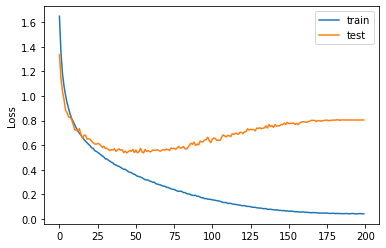

In [63]:
plt.plot(train_stat[:,1], label='train')
plt.plot(test_stat[:,1], label='test')
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_loss.svg")
plt.show()

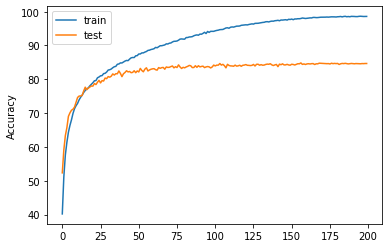

In [64]:
plt.plot(train_stat[:,2], label='train')
plt.plot(test_stat[:,2], label='test')
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_accs.svg")
plt.show()